# Patch Tuesday

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns


## Latest Microsoft security updates from the MSRC API
https://msrc.microsoft.com/update-guide/

In [75]:
# Get Microsoft security updates from MSRC API
updates = requests.get("https://api.msrc.microsoft.com/cvrf/v3.0/updates",
                       headers={"Accept": "application/json"}
                       )
latest_msrc_url = updates.json()["value"][-1]["CvrfUrl"]

# Get current CVRF from MSRC API
msrc_response = requests.get(latest_msrc_url, headers={"Accept": "application/json"})
msrc_json = msrc_response.json()
cves = list(set([x["CVE"] for x in msrc_json["Vulnerability"]]))

## EPSS (Exploit Prediction Scoring System) data for Microsoft security updates
See EPSS at https://www.first.org/epss

In [76]:
# Get latest EPSS data from First.org for MSRC CVEs
cve_chunk = len(cves) // 3
cve_chunks = [cves[i:i + cve_chunk] for i in range(0, len(cves), cve_chunk)]

df_list = []

for chunk in cve_chunks:
    epss_url = f"https://api.first.org/data/v1/epss.csv?cve={','.join(chunk)}"
    epss_data = pd.read_csv(epss_url)
    df_list.append(epss_data)

epss = pd.concat(df_list)

## CISA Known Exploited Vulnerabilities Catalog
https://www.cisa.gov/known-exploited-vulnerabilities-catalog

In [77]:
# Get CISA KEV (Known Exploited Vulnerabilities) data
cisa_kev = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")

# Filter CISA KEV data for MSRC CVEs
cisa_kev_msrc = cisa_kev[cisa_kev["cveID"].isin(cves)]

## Normalize and combine data from MSRC, EPSS, and CISA KEV

In [78]:
msrc_kev_epss_data = []

threat_type_mapping = {
    0: 'Impact',
    3: 'Severity',
    1: 'Exploit Status'
}

vulnerabilities = msrc_json.get('Vulnerability', [])

for vulnerability in vulnerabilities:
    cve = vulnerability.get("CVE", "")
    title = vulnerability.get("Title").get("Value", "")
    cvss_scores = [cvss.get("BaseScore", "") for cvss in vulnerability.get("CVSSScoreSets", [])]
    if cvss_scores:
        cvss_score = max(cvss_scores)
    else:
        cvss_score = None
    cisa_kev = cve in cisa_kev_msrc["cveID"].values

    epss_score = epss.loc[epss['cve'] == cve, 'epss'].values[0] if cve in epss['cve'].values else None

    threats = {}
    for threat in vulnerability.get("Threats", []):
        threat_type = threat_type_mapping.get(threat.get("Type", 0), "")
        threat_value = threat.get("Description").get("Value", "")
        threats.update({threat_type: threat_value})

    impact = threats.get('Impact', "")
    severity = threats.get('Severity', "")
    exploit_status = threats.get('Exploit Status', "")

    product = next((note.get("Value", "") for note in vulnerability.get("Notes", []) if note.get("Type") == 7), "")

    msrc_kev_epss_data.append([cve, title, cvss_score, cisa_kev, epss_score, product, impact, severity, exploit_status])

# Create a DataFrame from the data
df = pd.DataFrame(msrc_kev_epss_data,
                  columns=["CVE", "Title", "Max CVSS", "CISA KEV", "EPSS", "Product", "Impact", "Severity",
                           "Exploit Status"])

df

,CVE,Title,Max CVSS,CISA KEV,EPSS,Product,Impact,Severity,Exploit Status
0,CVE-2024-27281,,NaN,False,NaN,Mariner,,,DOS:N/A
1,CVE-2024-33599,,NaN,False,0.00043,Mariner,,,DOS:N/A
2,CVE-2024-33600,,NaN,False,0.00043,Mariner,,,DOS:N/A
3,CVE-2024-33874,,NaN,False,NaN,Mariner,,,DOS:N/A
4,CVE-2024-32612,,NaN,False,NaN,Mariner,,,DOS:N/A
...,...,...,...,...,...,...,...,...,...
175,CVE-2024-30054,Microsoft Power BI Client JavaScript SDK Infor...,6.5,False,0.00088,Power BI,Information Disclosure,Important,Publicly Disclosed:No;Exploited:No;Latest Soft...
176,CVE-2024-4331,Chromium: CVE-2024-4331 Use after free in Pict...,NaN,False,0.00044,Microsoft Edge (Chromium-based),,,DOS:N/A
177,CVE-2024-4368,Chromium: CVE-2024-4368 Use after free in Dawn,NaN,False,0.00044,Microsoft Edge (Chromium-based),,,DOS:N/A
178,CVE-2024-4761,Chromium: CVE-2024-4761 Out of bounds write in V8,NaN,True,0.00265,Microsoft Edge (Chromium-based),,,DOS:N/A


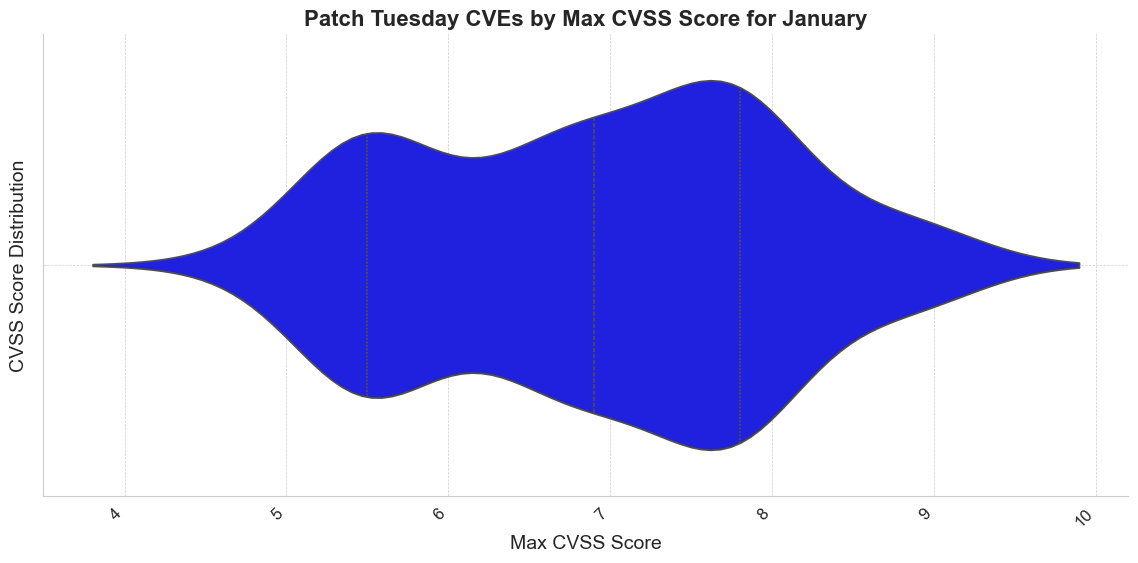

In [79]:
fig, axes = plt.subplots(figsize=(14, 6))
sns.set_style("whitegrid")

sns.violinplot(data=df, x='Max CVSS', ax=axes, inner='quartile', color='blue')

plt.title('Patch Tuesday CVEs by Max CVSS Score for January', fontsize=16, fontweight='bold')
plt.xlabel('Max CVSS Score', fontsize=14)
plt.ylabel('CVSS Score Distribution', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
axes.grid(True, which='both', linestyle='--', linewidth=0.5)

sns.despine()

plt.show()

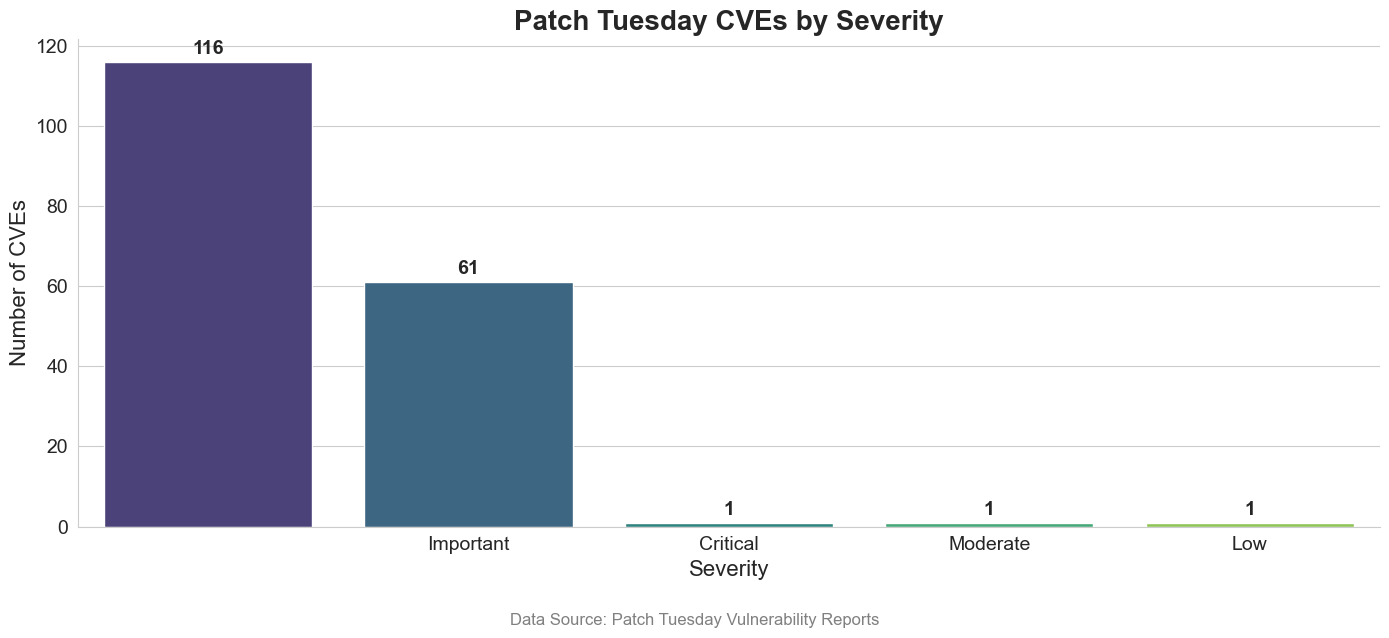

In [80]:
# Count the number of CVEs for each severity level
severity_counts = df['Severity'].value_counts()

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 6))
sns.set_style("whitegrid")

# Create the bar plot
palette = sns.color_palette("viridis", len(severity_counts))
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette=palette, ax=ax, hue=severity_counts.index,
            legend=False)

# Set the title and labels with custom fonts and sizes
plt.title('Patch Tuesday CVEs by Severity', fontsize=20, fontweight='bold')
plt.xlabel('Severity', fontsize=16)
plt.ylabel('Number of CVEs', fontsize=16)

# Add annotations on top of each bar
for i in range(len(severity_counts)):
    ax.text(i, severity_counts.values[i] + 1, f"{severity_counts.values[i]}", ha='center', va='bottom', fontsize=14,
            fontweight='bold')

# Rotate x-axis labels if necessary
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)

# Removing the top and right spines for a cleaner look
sns.despine()

# Adding a caption
fig.text(0.5, -0.05, 'Data Source: Patch Tuesday Vulnerability Reports', ha='center', fontsize=12, color='gray')

plt.tight_layout()
plt.show()

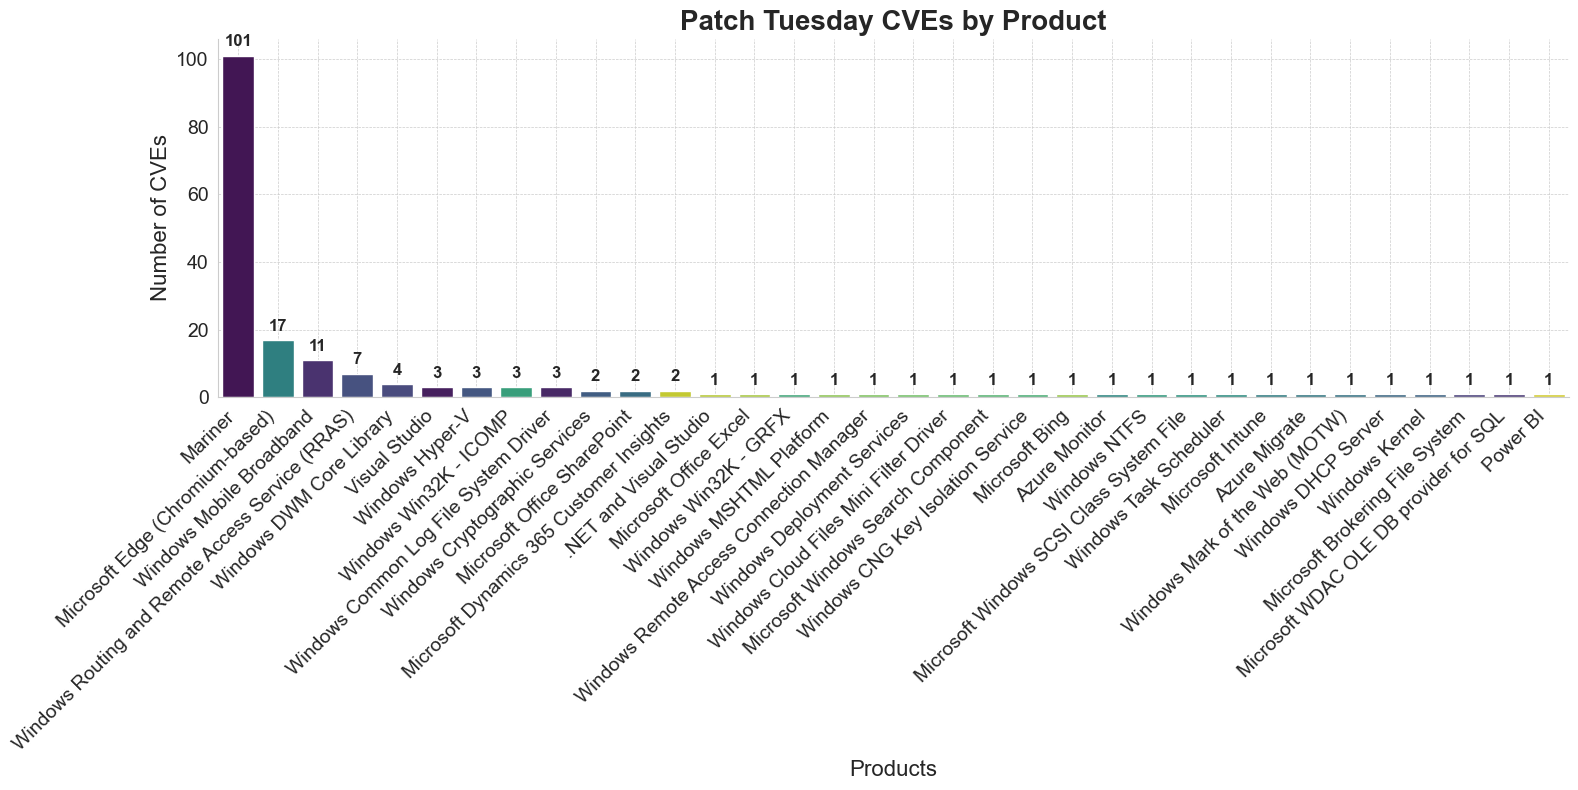

In [81]:
sns.set_style("whitegrid")

num_products = df['Product'].nunique()

fig, axes = plt.subplots(figsize=(16, 8))

palette = sns.color_palette("viridis", num_products)
sns.countplot(data=df, x='Product', ax=axes, order=df['Product'].value_counts().index, palette=palette, hue='Product',
              legend=False)

plt.title('Patch Tuesday CVEs by Product', fontsize=20, fontweight='bold')
plt.xlabel('Products', fontsize=16)
plt.ylabel('Number of CVEs', fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=14)

plt.yticks(fontsize=14)

axes.grid(True, which='both', linestyle='--', linewidth=0.5)

for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center',
                  xytext=(0, 10),
                  textcoords='offset points', fontsize=12, fontweight='semibold')

sns.despine()
plt.tight_layout()
plt.show()